In [1]:
import skxray.core.speckle as xsvs
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

from lmfit import Model
import skxray.core.fitting.lineshapes as linesh

import xray_vision.mpl_plotting as mpl_plot
import xray_vision.mpl_plotting.speckle as speckle_plot

import numpy as np
import os, sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid

:0: FutureWarning: IPython widgets are experimental and may change in the future.


###Easily switch between interactive and static matplotlib plots

In [2]:
interactive_mode = False

if interactive_mode:
    %matplotlib notebook
else:
    %matplotlib inline

backend = mpl.get_backend()

##This data provided by Dr. Andrei Fluerasu
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu , "Photon statistics and speckle visibility spectroscopy with partially coherent x-rays"
J. Synchrotron Rad., vol 21, p 1288-1295, 2014.

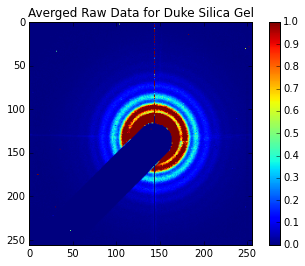

In [3]:
data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/Duke_data/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data=np.asarray(duke_data)

avg_raw = np.average(duke_data, axis=0)

plt.figure()
plt.imshow(avg_raw, vmin=0, vmax=1e0)
plt.title("Averged Raw Data for Duke Silica Gel")
plt.colorbar()
plt.show()

##Masking
different masks can be multiplied or added to create a combined mask
Masks can be created using xray_vision/mask/manual_mask module
https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

In [4]:
mask4 = np.load(data_dir+"new_mask4.npy")
mask = np.load(data_dir+"Luxi_duke_mask.npy")

# mask can be multiplied or added in the follwoing way
N_mask = (~mask * ~mask4)
#or N_mask = ~(mask + mask4)


##Use the skxray.core.roi module to create Ring ROIs(ROI Mask)

In [5]:
inner_radius = 26
width = 1
spacing = 0
num_rings = 4

#  create edges of the rings using roi.ring_edges
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 26.,  27.],
       [ 27.,  28.],
       [ 28.,  29.],
       [ 29.,  30.]])

##create a labeled array using roi.rings

In [6]:
est_center = (133, 143)  # center of the speckle pattern

rings = roi.rings(edges, est_center, avg_raw.shape)

rings_mask = rings*N_mask

##Convert the ring edges to q (reciprocal values)

In [7]:
dpix = 0.055  # pixel size
lambda_ = 1.5498  # wavelength
Ldet = 2200.   #   # distance to sample

two_theta = core.radius_to_twotheta(Ldet, edges*dpix)
q_val = core.twotheta_to_q(two_theta, lambda_)
q_val

array([[ 0.00263522,  0.00273658],
       [ 0.00273658,  0.00283793],
       [ 0.00283793,  0.00293929],
       [ 0.00293929,  0.00304064]])

In [8]:
q_cen = np.mean(q_val, axis=1)
q_cen

array([ 0.0026859 ,  0.00278726,  0.00288861,  0.00298997])

##Get the mean intensity of each ring

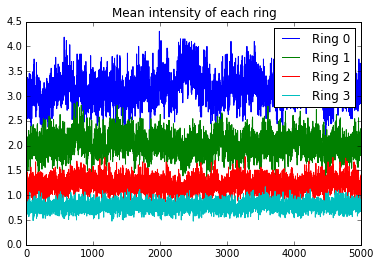

In [9]:
images_sets = N_mask*duke_data

mean_int_sets, index_list = roi.mean_intensity(images_sets, rings_mask)

plt.figure()
plt.title("Mean intensity of each ring")
for i in range(num_rings):
    plt.plot(mean_int_sets[:, i], label="Ring "+str(i))
plt.legend()    
plt.show()

In [10]:
mean_int_ring = np.mean(mean_int_sets, axis=0)
mean_int_ring

array([ 3.17503051,  2.03199322,  1.22062687,  0.78536136])

##Find the brightest pixel in any ROI in any image in the image set.¶
Using roi_max_counts function from skxray.core.roi module

In [11]:
max_cts = roi.roi_max_counts((N_mask*duke_data, ), rings_mask)
max_cts

24

###Everything looks good, next X-ray speckle visibilty spectroscopy
This function will provide the probability density of detecting photons for different integration time. 
Using skxray.core.speckle module

In [12]:
spe_cts_all, std_dev = xsvs.xsvs((duke_data*N_mask, ), rings_mask, timebin_num=2,
                             number_of_img=50, max_cts=max_cts)


##Get the normalized bin edges and bin centers for each integration time.¶
using skxray.core.speckle.normalize_bin_edges

In [13]:
num_times = 6
num_rois=num_rings
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

In [14]:
norm_bin_edges[0,0].shape[0], norm_bin_edges[1,0].shape, norm_bin_edges[2,0].shape,norm_bin_edges[3,0].shape

(24, (48,), (96,), (192,))

In [15]:
bin_cen = []
ring_avg = []
for i in range(num_times):
    bin_center, ring_ave = roi.circular_average(avg_raw*mask, est_center,
                                             threshold=0, nx=max_cts*2**i,
                                             pixel_size=(dpix, dpix))
    bin_cen.append(bin_center)
    ring_avg.append(ring_ave)

ring_avg = np.asarray(ring_avg)

##Find the integration times
using skxray.core.utils.geometric_series

In [16]:
time_steps = core.geometric_series(2, 50)
time_steps

[1, 2, 4, 8, 16, 32]

##1st q ring 0.0026859 (1/Angstroms)

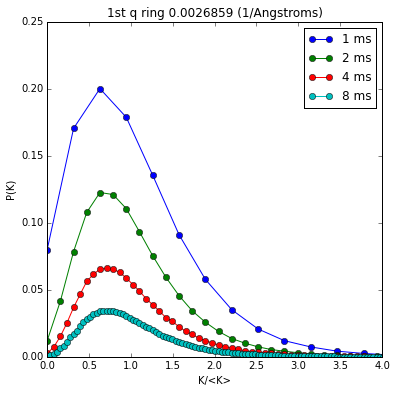

In [17]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.set_xlabel("K/<K>")
axes.set_ylabel("P(K)")
for i in range(4):
    art, = axes.plot(norm_bin_edges[i, 0][:-1], spe_cts_all[i, 0], '-o', label=str(time_steps[i])+" ms")
    axes.set_xlim(0, 4)
    axes.legend()
plt.title("1st q ring 0.0026859 (1/Angstroms)")
plt.show()

In [18]:
import scipy
from scipy.stats import gamma, poisson, nbinom

In [19]:
from lmfit import  Model

g_mod = Model(linesh.gamma_dist)
n_mod = Model(linesh.nbinom_dist)
p_mod = Model(linesh.poisson_dist)
#mod = Model(corr.auto_corr_scat_factor)

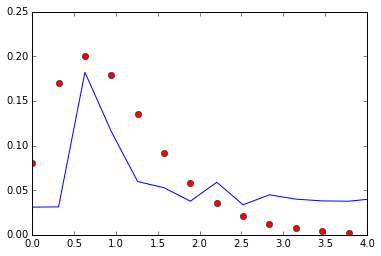

In [37]:
result_n = n_mod.fit(spe_cts_all[0, 0], intensity=ring_avg[0][:-1], K=2.345, M=1.234)

plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all[0,0], 'ro')
plt.plot(norm_bin_edges[0, 0][:-1], result_n.best_fit, '-b')
plt.xlim(0, 4)
plt.show()

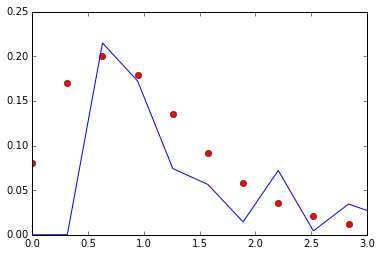

In [36]:
result_g = g_mod.fit(spe_cts_all[0, 0], intensity=ring_avg[0][:-1],
                     K=mean_int_ring[0], M=0.876)

plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all[0,0], 'ro')
plt.plot(norm_bin_edges[0, 0][:-1], result_g.best_fit, '-b')
plt.xlim(0, 3)
plt.show()

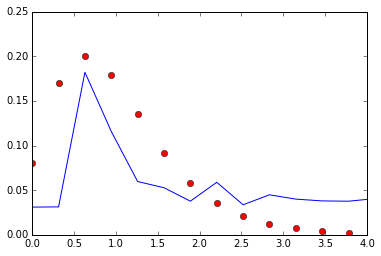

In [27]:
result_p = p_mod.fit(spe_cts_all[0, 0], intensity=ring_avg[0][:-1], K=1.4)

plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all[0,0], 'ro')
plt.plot(norm_bin_edges[0, 0][:-1], result_p.best_fit, '-b')
plt.xlim(0, 4)
plt.show()